In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot 
import cv2
import random
import os
import glob
from tqdm.notebook import tqdm
import albumentations as A
import tensorflow as tf

In [3]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix 
from keras.callbacks import ReduceLROnPlateau

In [4]:
train_data = glob.glob('chest_xray/train/**/*.jpeg')
test_data = glob.glob('chest_xray/test/**/*.jpeg')
val_data = glob.glob('chest_xray/val/**/*.jpeg')
print("〰"*20)
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print("〰"*20)
DIR = "chest_xray/"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []
for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)
print("〰"*20)
print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Training Set has: 5232 images
Testing Set has: 624 images
Validation Set has: 16 images
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Total Pneumonia Images: 4281
Total Normal Images: 1591
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [5]:
labels = ["Normal",'Pneumonia ']
values = [len(all_normal), len(all_pneumonia)] 
colors = ['green', 'pink']
fig = go.Figure(data=[go.Pie(labels=labels,values=values,hole=.5)]) 
fig.update_traces(hoverinfo='value', textinfo='label+percent', textfont_size=20,marker=dict(colors=colors, line=dict(color='#000000', width=3))) 
fig.update_layout(title="Image Category Distribution",
titlefont={'size': 30},) 
iplot(fig)

In [13]:
random.shuffle(all_normal) 
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]

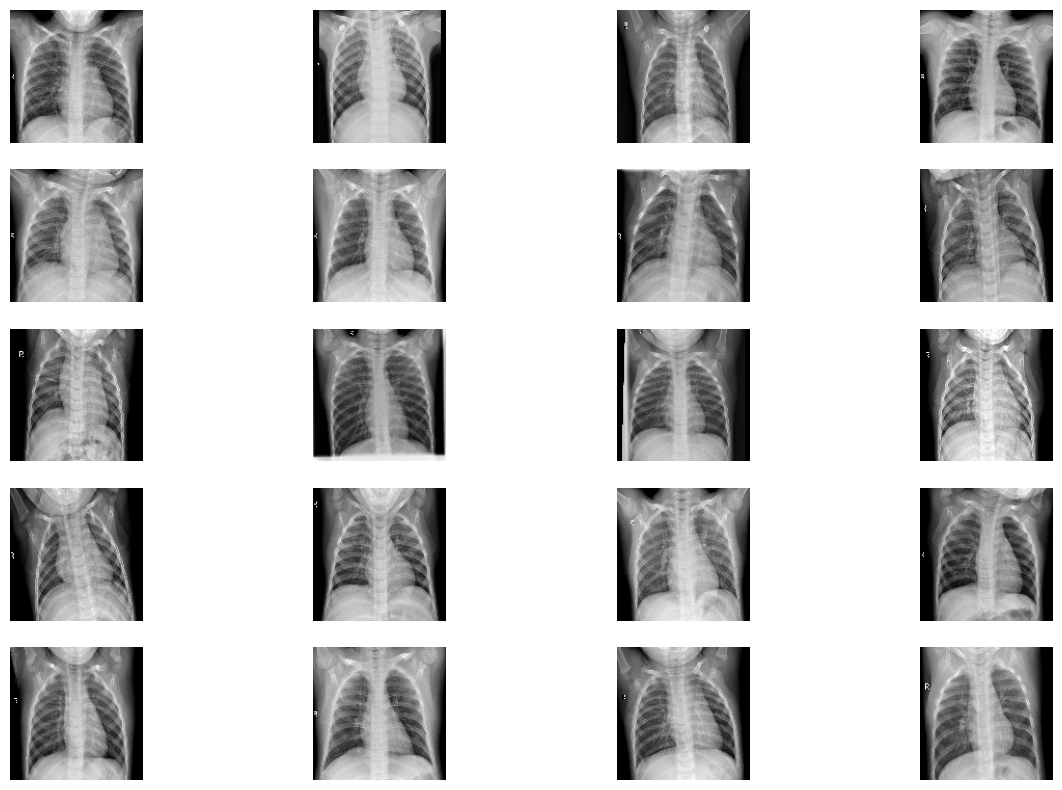

In [14]:
fig=plt.figure(figsize=(15, 10)) 
columns = 4; rows = 5
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128)) 
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

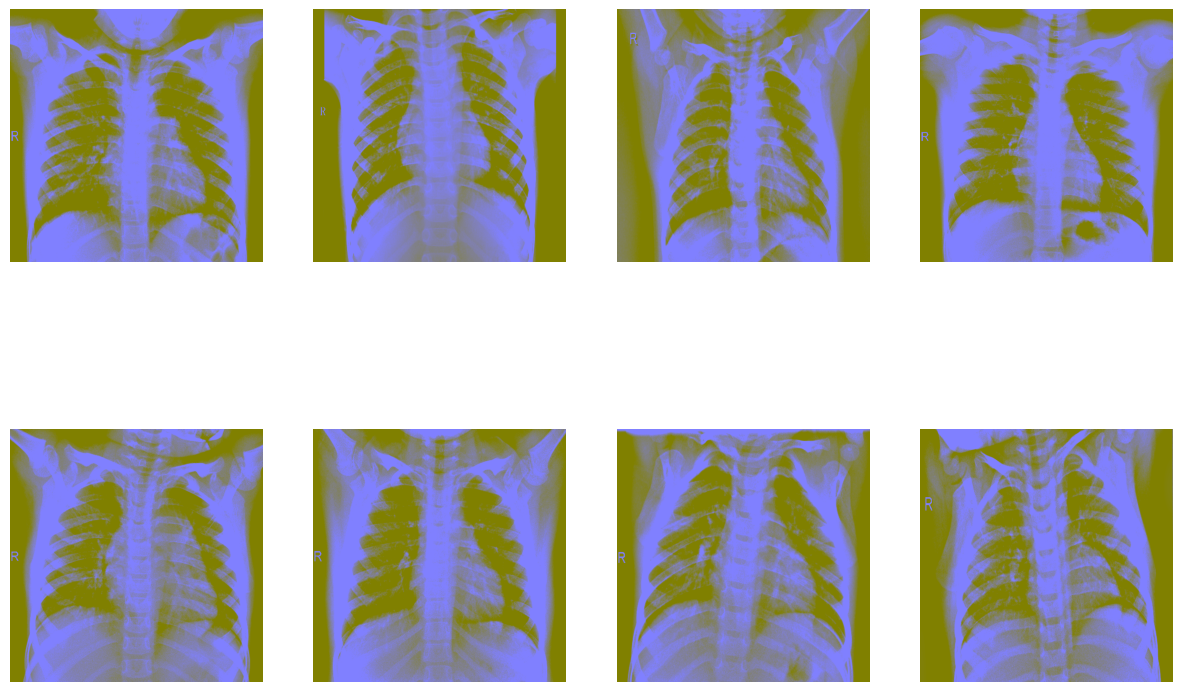

In [15]:
fig=plt.figure(figsize=(15, 10)) 
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128) 
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

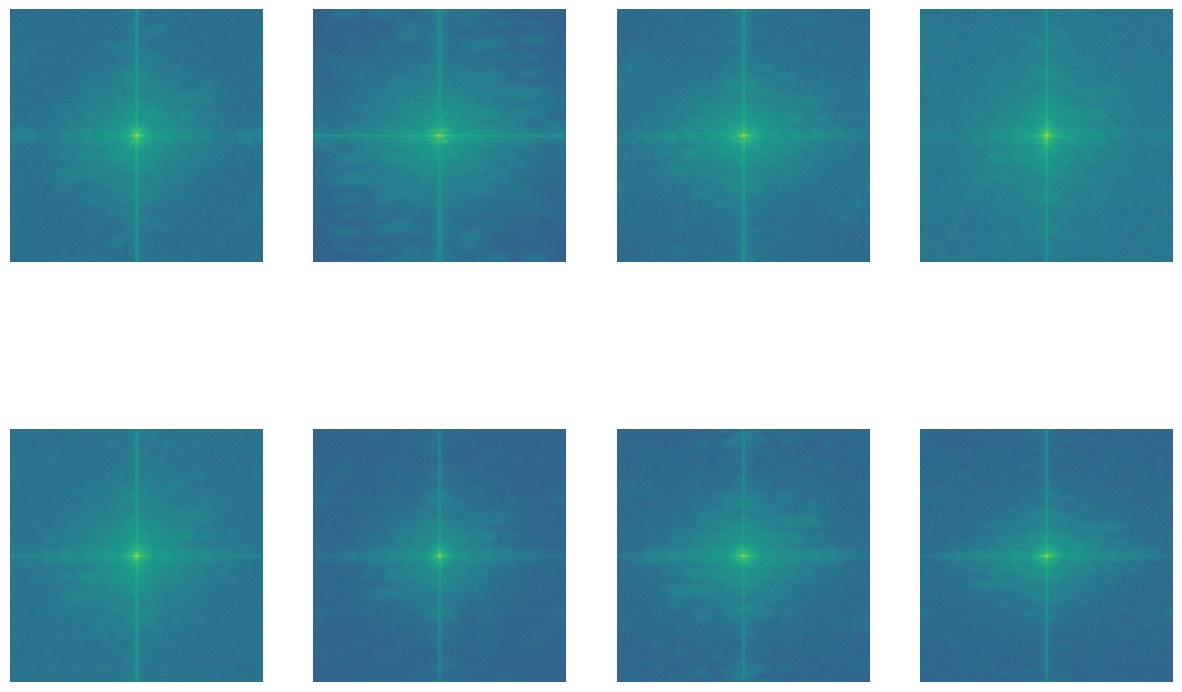

In [16]:
fig=plt.figure(figsize=(15, 10)) 
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift)) 
    fig.add_subplot(rows, columns, i) 
    plt.imshow(magnitude_spectrum)
    plt.axis(False)

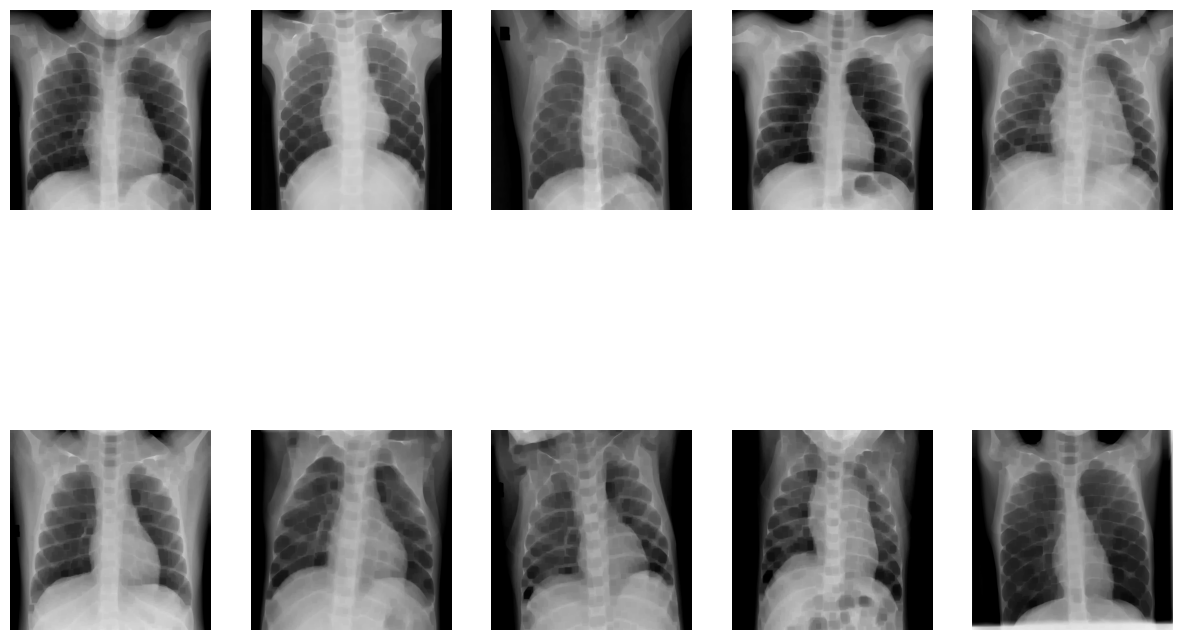

In [17]:
fig=plt.figure(figsize=(15, 10)) 
columns = 5; 
rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3) 
    fig.add_subplot(rows, columns, i) 
    plt.imshow(img_erosion)
    plt.axis(False)

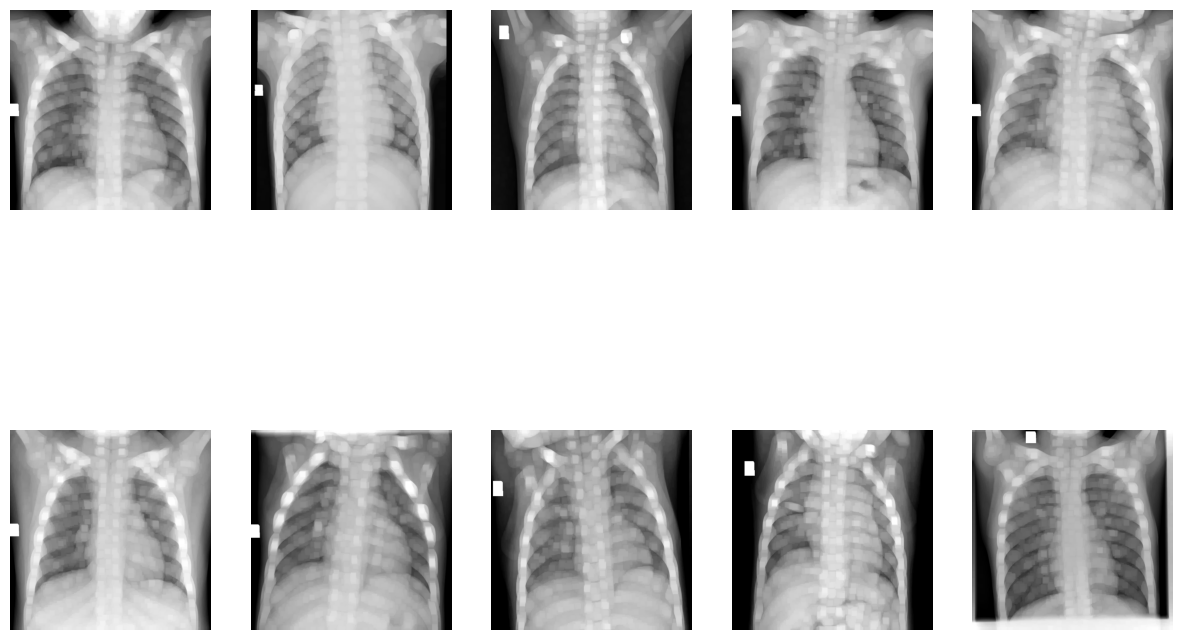

In [18]:
fig=plt.figure(figsize=(15, 10)) 
columns = 5; 
rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3) 
    fig.add_subplot(rows, columns, i) 
    plt.imshow(img_erosion)
    plt.axis(False)

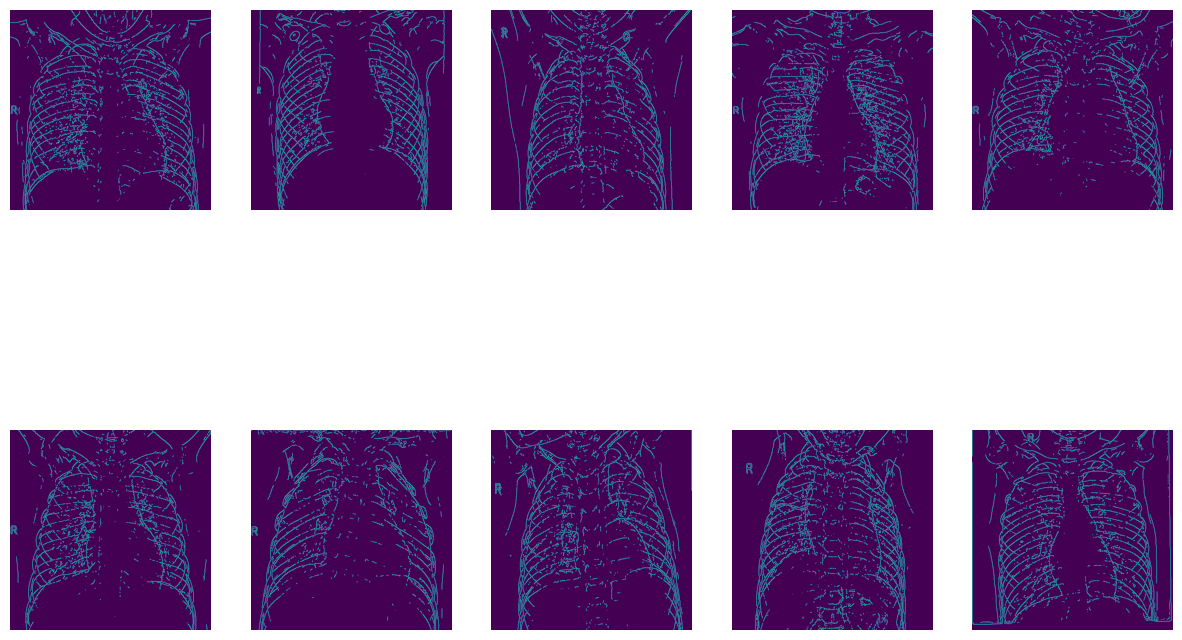

In [19]:
fig=plt.figure(figsize=(15, 10)) 
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    edges = cv2.Canny(img, 80, 100) 
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)

In [20]:
train_gen = ImageDataGenerator(
 rescale=1/255.,
 horizontal_flip=True,
 vertical_flip=False,
 rotation_range=0.3,
 zoom_range=0.4
)
val_gen = ImageDataGenerator(
 rescale=1/255.,
)
Train = train_gen.flow_from_directory(
 "chest_xray/train",batch_size=16,
 target_size=(224, 224),#class_mode="binary" 
)
val = train_gen.flow_from_directory(
 "chest_xray/test",batch_size=8,
 target_size=(224, 224),#class_mode="binary" 
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [21]:
#Convolution Neural Network Architecture
model = Sequential()
model.add(Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', 
input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
history = model.fit(Train,validation_data=val,epochs=20,steps_per_epoch=50,callbacks=[early_stopping_cb]) 

Epoch 1/20
50/50 [==============================] - 50s 1s/step - loss: 0.4944 - accuracy: 0.7550 - val_loss: 0.8121 - val_accuracy: 0.6234
Epoch 2/20
50/50 [==============================] - 55s 1s/step - loss: 0.4309 - accuracy: 0.8012 - val_loss: 0.6666 - val_accuracy: 0.7372
Epoch 3/20
50/50 [==============================] - 51s 1s/step - loss: 0.4278 - accuracy: 0.7925 - val_loss: 0.6475 - val_accuracy: 0.7228
Epoch 4/20
50/50 [==============================] - 52s 1s/step - loss: 0.4074 - accuracy: 0.8250 - val_loss: 0.5845 - val_accuracy: 0.7276
Epoch 5/20
50/50 [==============================] - 52s 1s/step - loss: 0.3454 - accuracy: 0.8475 - val_loss: 0.6435 - val_accuracy: 0.7564
Epoch 6/20
50/50 [==============================] - 48s 946ms/step - loss: 0.3119 - accuracy: 0.8637 - val_loss: 0.4853 - val_accuracy: 0.7692
Epoch 7/20
50/50 [==============================] - 50s 992ms/step - loss: 0.3119 - accuracy: 0.8662 - val_loss: 0.4293 - val_accuracy: 0.8093
Epoch 8/20
50/

Found 624 images belonging to 2 classes.
50/50 [==============================] - 7s 132ms/step


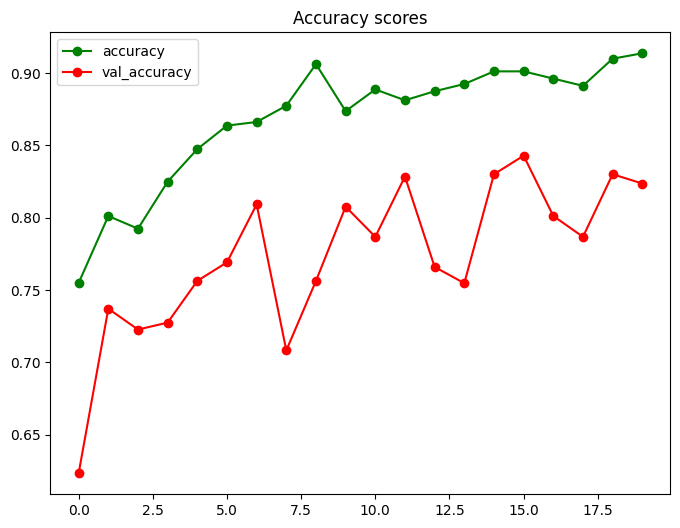

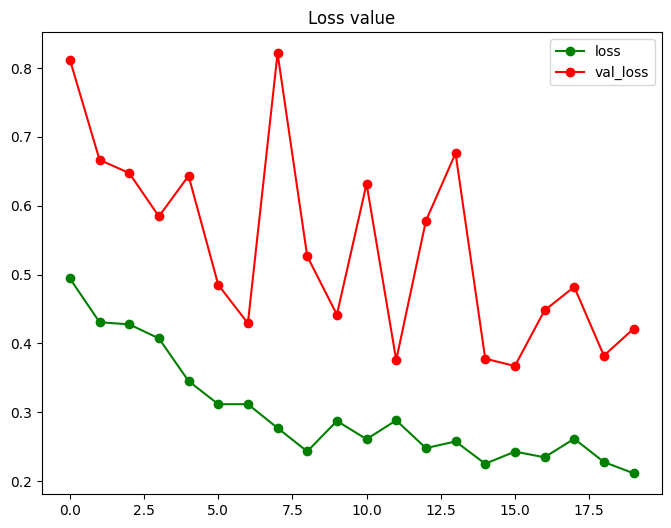

In [52]:
# Visualization of model performance
test = train_gen.flow_from_directory(
    # class_mode="binary"
    "chest_xray/test", batch_size=8, target_size=(224, 224),
)

predict = model.predict(test, steps=np.ceil(400/8))


def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(
        hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])

    file_names = test.test_generators.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count):
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))
            m[num] = 1
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"\\" + file_names[num], 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        title_text = ("%s%s%s%s%s" %
                      ("True: ", original, "\n", "Pred: ", predicted))
        if original == predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
        if plot_params["update_image"] and os.path.exists(image_file_name):
            os.remove(image_file_name)
        fig.savefig(image_file_name, dpi=subplot_params["dpi"])
        plt.tight_layout()
        plt.show()
    image_file_name_batch = "/chest_xray/train"
    image_file_name_sample = "/chest_xray/test"
    batch_size_t = 8
    class_map = {v: k for k, v in test.test_generators.class_indices.items()}
    dpi = 100
    ncols = 8
    nrows = 4
    count = ncols*nrows
    subplot_params = plt.get_reset_subplot_params(nrows, ncols, dpi)
    plot_params = plt.get_reset_plot_params()
    show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params,
                 plot_params, class_map, testing_dir, image_file_name_batch, count, sample)

plt.figure(figsize=(8, 6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'], 'go-')
plt.plot(history.history['val_accuracy'], 'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8, 6))
plt.title('Loss value')
plt.plot(history.history['loss'], 'go-')
plt.plot(history.history['val_loss'], 'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

Found 624 images belonging to 2 classes.
50/50 [==============================] - 7s 132ms/step


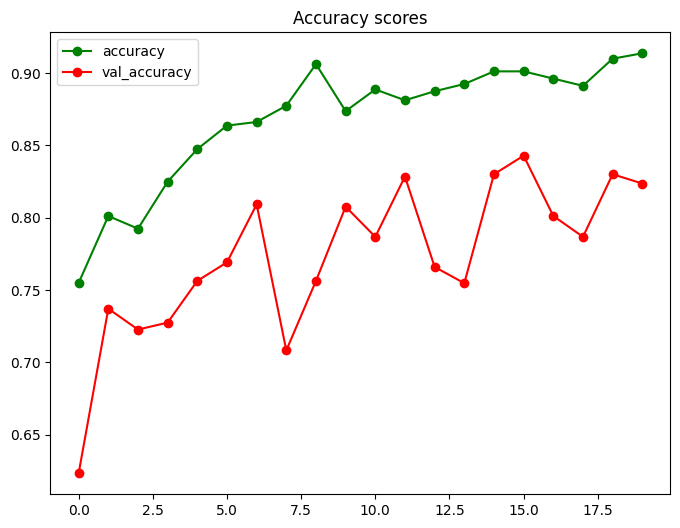

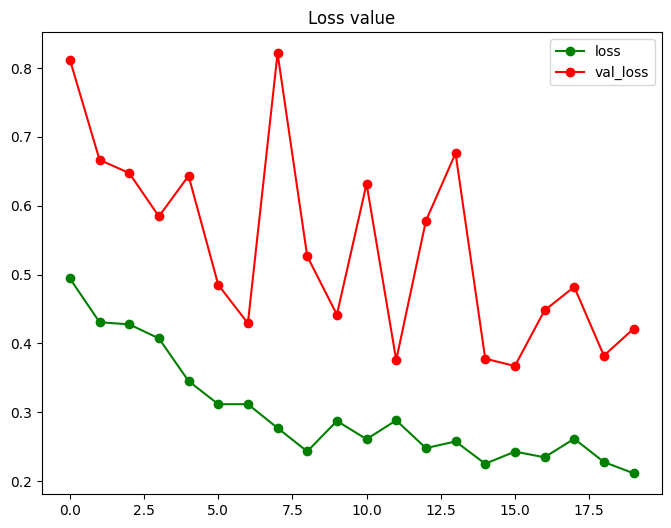

In [56]:
# Visualization of model performance
test = train_gen.flow_from_directory(
    # class_mode="binary"
    "chest_xray/test", batch_size=8, target_size=(224, 224),
)

predict = model.predict(test, steps=np.ceil(400/8))


def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(
        hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])

    file_names = test.test_generators.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count):
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))
            m[num] = 1
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"\\" + file_names[num], 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        title_text = ("%s%s%s%s%s" %
                      ("True: ", original, "\n", "Pred: ", predicted))
        if original == predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
        if plot_params["update_image"] and os.path.exists(image_file_name):
            os.remove(image_file_name)
        fig.savefig(image_file_name, dpi=subplot_params["dpi"])
    plt.tight_layout()
    plt.show()


    image_file_name_batch = "/chest_xray/train"
    image_file_name_sample = "/chest_xray/test"
    batch_size_t = 8
    class_map = {v: k for k, v in test.test_generators.class_indices.items()}
    dpi = 100
    ncols = 8
    nrows = 4
    count = ncols*nrows
    subplot_params = plt.get_reset_subplot_params(nrows, ncols, dpi)
    plot_params = plt.get_reset_plot_params()
    show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params,
                 plot_params, class_map, testing_dir, image_file_name_batch, count, sample)


plt.figure(figsize=(8, 6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'], 'go-')
plt.plot(history.history['val_accuracy'], 'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8, 6))
plt.title('Loss value')
plt.plot(history.history['loss'], 'go-')
plt.plot(history.history['val_loss'], 'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()
